In [1]:
%load_ext autoreload
%autoreload 2

%cd /home/rmhl/repos/stargraph

[Errno 2] No such file or directory: '/home/rmhl/repos/stargraph'
/Users/perper/Documents/active-learning/mnistvae


In [2]:
%load_ext autoreload
%autoreload 2
%cd /Users/perper/Documents/active-learning/mnistvae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/perper/Documents/active-learning/mnistvae


In [3]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "9"
os.environ["TF_USE_NVLINK_FOR_PARALLEL_COMPILATION"] = "0"
p = os.environ["PATH"]
os.environ["PATH"] = f"{p}:/usr/local/cuda/bin"

from functools import partial
import jax
import jax.numpy as jnp
from jaxtyping import PyTree
from torch.utils.data import DataLoader
import equinox as eqx
import matplotlib.pyplot as plt
import distrax as dsx
import optax
import seaborn as sns

sns.set()

#from data import SpokenMNISTMultimodalDataset
from model.image_vae import ImageVAE, ImageVAEOutput
from model.loss import ELBOLossOutput, get_evidence_lower_bound
from model.visualization import visualize_reconstructions


BATCH_SIZE = 16

In [4]:
import tensorflow_datasets as tfds

In [5]:
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import numpy as np

In [83]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
batch_size = BATCH_SIZE
random_seed = 42

MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)


def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


In [84]:
train_dataloader = load_dataset(tfds.Split.TRAIN, batch_size)
test_dataloader = load_dataset(tfds.Split.TEST, batch_size)

2023-11-14 11:26:43.343336: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


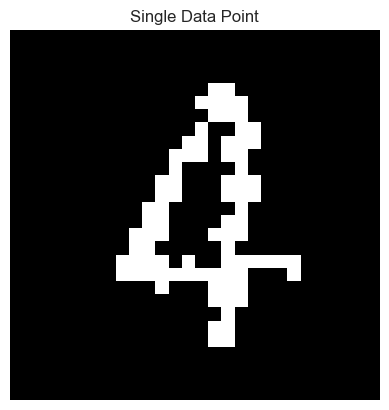

In [85]:
batch = next(train_dataloader)

# Take the first data point from the batch
data_point = batch['image'][0]
import matplotlib.pyplot as plt
plt.imshow(data_point.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point')
plt.axis('off')
plt.show()

In [9]:
#from data import SpokenMNISTMultimodalDataset

In [32]:
# train_dataloader = DataLoader(
#     SpokenMNISTMultimodalDataset(split="train"),
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=1,
# )
# test_dataloader = DataLoader(
#     SpokenMNISTMultimodalDataset(split="test"),
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=1,
# )

In [10]:
from model.encoder import ImageEncoder

key = jax.random.PRNGKey(0)
encoder = ImageEncoder(in_channels=1, out_channels=2, key=key)
encoder_fn = jax.vmap(encoder)
#image_input_example = jax.random.normal(key, (32, 32))
#encoder_output = encoder(image_input_example)
#encoder_output
#batch = batch[..., 0]
#targets = pad_fn(batch)
#encoder_fn(batch)
#batch.shape

In [11]:
key = jax.random.PRNGKey(0)

model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=1, n_latents=2, key=model_key)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

pad_fn = jax.vmap(partial(jnp.pad, pad_width=2))


@eqx.filter_value_and_grad(has_aux=True)
def grad_and_loss(model: eqx.Module, batch: jnp.array, key: jax.random.PRNGKey):
    model_fn = jax.vmap(model)
    loss_fn = jax.vmap(get_evidence_lower_bound)
    keys = jax.random.split(key, BATCH_SIZE)
    model_output: ImageVAEOutput = model_fn(batch, key=keys)
    loss_output: ELBOLossOutput = loss_fn(batch, model_output)
    return jnp.mean(loss_output["loss"]), jax.tree_map(jnp.mean, loss_output)


@eqx.filter_jit
def make_step(
    model: eqx.Module,
    opt_state: PyTree,
    batch: jnp.array,
    *,
    key: jax.random.PRNGKey,
):
    (loss, aux), grads = grad_and_loss(model, batch, key)
    updates, update_opt_state = optimizer.update(grads, opt_state)
    update_model = eqx.apply_updates(model, updates)
    return (loss, aux), update_model, update_opt_state


step = 0
MAX_EPOCHS = 10
train_metrics = None
for epoch in range(MAX_EPOCHS):
    for batch in train_dataloader:
        batch = jnp.asarray(batch["image"]).astype(jnp.float32)
        batch = np.squeeze(batch)
        targets = pad_fn(batch)
        key, binarized_key = jax.random.split(key)
        targets = (
            dsx.Bernoulli(probs=targets).sample(seed=binarized_key).astype(jnp.float32)
        )
        key, step_key = jax.random.split(key)
        (loss, aux), model, opt_state = make_step(
            model, opt_state, targets, key=step_key
        )

        step += 1
        if step % 500 == 0:
            if train_metrics is None:
                train_metrics = {k: jnp.array([v]) for k, v in aux.items()}
                train_metrics["step"] = jnp.array([step])
            else:
                for k, v in aux.items():
                    train_metrics[k] = jnp.concatenate(
                        [train_metrics[k], jnp.array([v])]
                    )
                train_metrics["step"] = jnp.concatenate(
                    [train_metrics["step"], jnp.array([step])]
                )

            log_str = f"step/epoch: {step}/{epoch}"
            for k, v in aux.items():
                log_str += f"\t {k}: {v:.3f}"
            print(log_str)

visualize_reconstructions(model, targets)

K = len(train_metrics) - 1
plt.figure(figsize=(4 * K, 4))
for i, (k, v) in enumerate(train_metrics.items()):
    if k == "step":
        continue
    plt.subplot(1, K, i + 1)
    plt.title(k)
    plt.plot(train_metrics["step"], v)
    plt.xlabel("Optimization step")

step/epoch: 500/0	 distortion: 0.174	 loss: 0.175	 rate: 0.002
step/epoch: 1000/0	 distortion: 0.184	 loss: 0.186	 rate: 0.002
step/epoch: 1500/0	 distortion: 0.162	 loss: 0.167	 rate: 0.005
step/epoch: 2000/0	 distortion: 0.152	 loss: 0.158	 rate: 0.006
step/epoch: 2500/0	 distortion: 0.153	 loss: 0.158	 rate: 0.005
step/epoch: 3000/0	 distortion: 0.150	 loss: 0.156	 rate: 0.006
step/epoch: 3500/0	 distortion: 0.147	 loss: 0.153	 rate: 0.006
step/epoch: 4000/0	 distortion: 0.150	 loss: 0.156	 rate: 0.005
step/epoch: 4500/0	 distortion: 0.142	 loss: 0.148	 rate: 0.006
step/epoch: 5000/0	 distortion: 0.149	 loss: 0.155	 rate: 0.006
step/epoch: 5500/0	 distortion: 0.171	 loss: 0.177	 rate: 0.006
step/epoch: 6000/0	 distortion: 0.139	 loss: 0.145	 rate: 0.006
step/epoch: 6500/0	 distortion: 0.119	 loss: 0.125	 rate: 0.006
step/epoch: 7000/0	 distortion: 0.132	 loss: 0.138	 rate: 0.006
step/epoch: 7500/0	 distortion: 0.148	 loss: 0.153	 rate: 0.005
step/epoch: 8000/0	 distortion: 0.139	 lo

KeyboardInterrupt: 

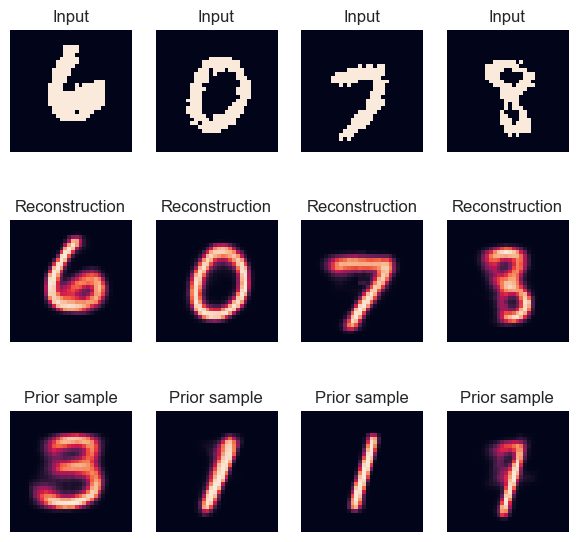

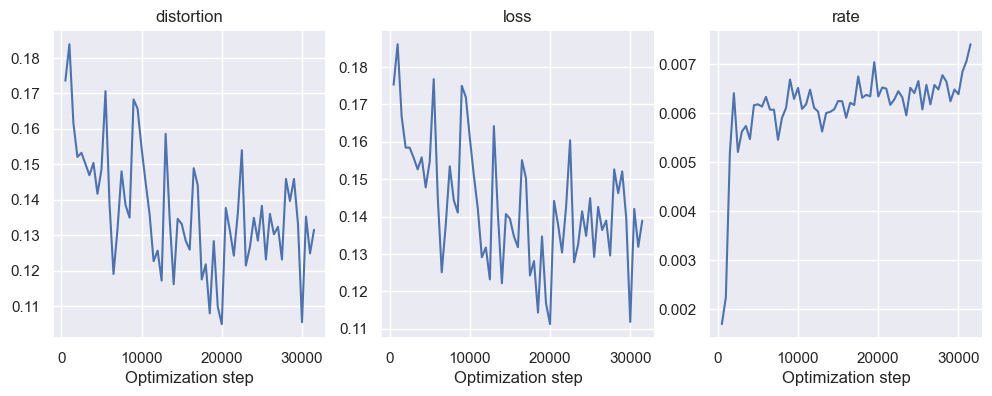

In [12]:
visualize_reconstructions(model, targets)

K = len(train_metrics) - 1
plt.figure(figsize=(4 * K, 4))
for i, (k, v) in enumerate(train_metrics.items()):
    if k == "step":
        continue
    plt.subplot(1, K, i + 1)
    plt.title(k)
    plt.plot(train_metrics["step"], v)
    plt.xlabel("Optimization step")

In [179]:
from acquiring.sample_image import sample_a_image, get_next,update_images, binary_cross_entropy

In [164]:
#Pre_Process:
Nz = 10
Nx = 5


sample_a_image_fn = jax.vmap(sample_a_image, in_axes=(None, None, None, 0, 0))
get_next_fn = jax.vmap(get_next)
update_images_fn = jax.vmap(update_images)


model_fn = jax.vmap(model)
keys = jax.random.split(key, BATCH_SIZE)

In [166]:
orginial_images = np.squeeze(batch['image'])

orginial_images= orginial_images.astype(np.float32)
images_float = orginial_images
half_height = images_float.shape[1] // 2
images_with_top_half_missing = images_float.copy()
images_with_top_half_missing[:, :half_height, :] = np.nan
#Get mask
mask_missing = np.isnan(images_with_top_half_missing)
mask_observed = ~mask_missing
images_refill = update_images_fn(orginial_images,mask_observed)

#Shape
mask_observed = pad_fn(mask_observed)
images_refill = pad_fn(images_refill)
orginial_images = pad_fn(orginial_images)

In [167]:
#demo 
a = sample_a_image(Nz, Nx,model, orginial_images[0], key)
img, msk= get_next(a, mask_observed[0],images_refill[0],orginial_images[0])
print(np.sum(msk))

The value at index (Array(15, dtype=int32), Array(17, dtype=int32)) is: 0.0
393


In [168]:
def update(images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    batch_rng = jax.random.split(rng, batch_size) 
    #mean, log_var = encoder.apply(new_encoder_params, rng_miss, images)
    R = sample_a_image_fn(Nz, Nx,model,orginial_images, batch_rng)
    images_updated, mask_return = get_next_fn(R, mask_observed, images,orginial_images)
    return images_updated, mask_return

Step 0: Mean Log Likelihood = -686.752197265625


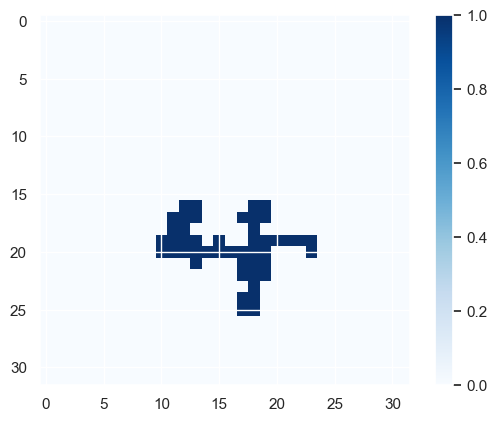

Step 10: Mean Log Likelihood = -684.852783203125


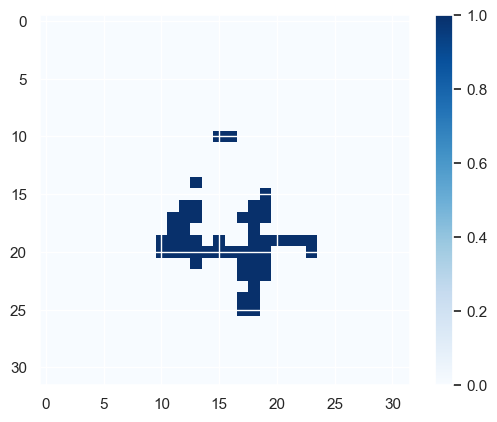

Step 20: Mean Log Likelihood = -683.1907958984375


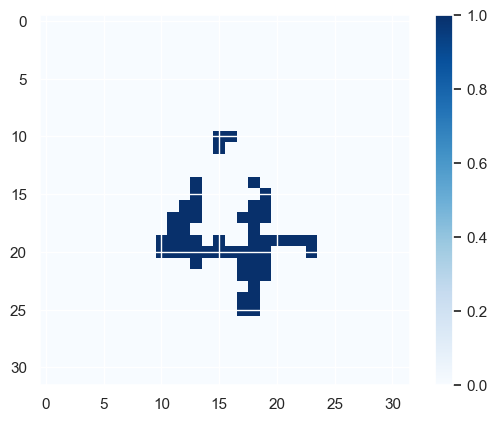

Step 30: Mean Log Likelihood = -681.0064697265625


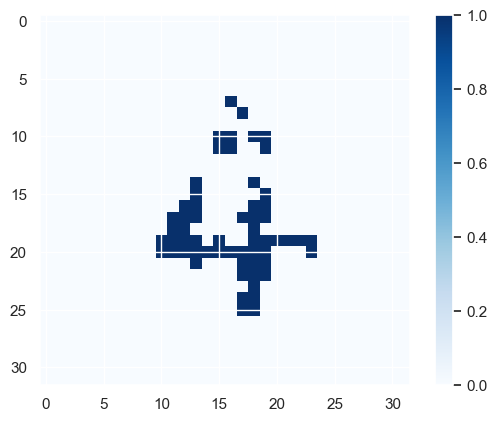

Step 40: Mean Log Likelihood = -679.296875


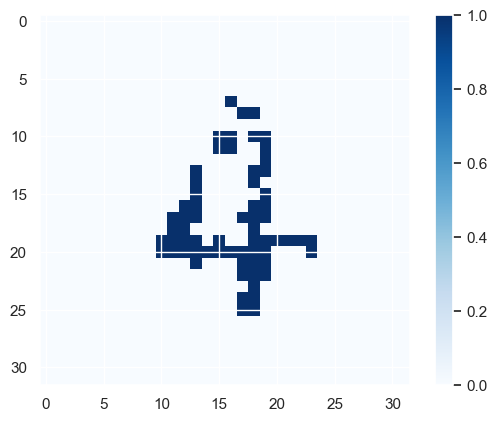

Step 50: Mean Log Likelihood = -677.46875


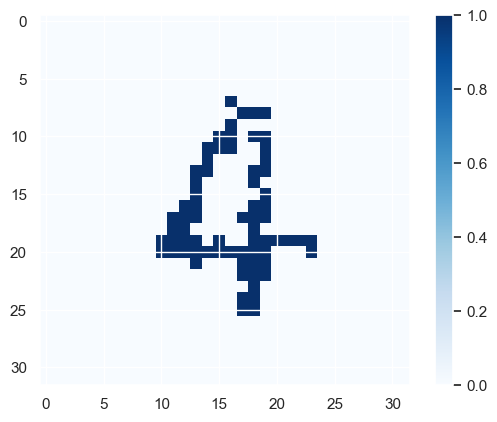

Step 60: Mean Log Likelihood = -676.3291015625


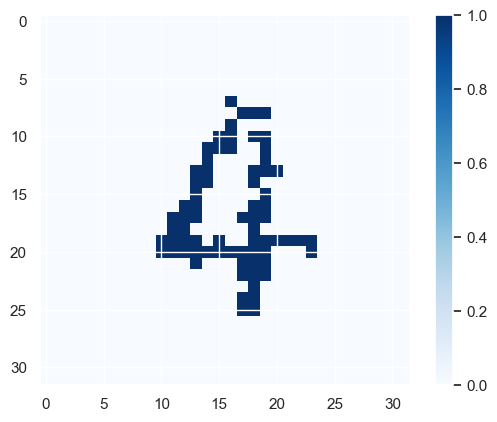

Step 70: Mean Log Likelihood = -675.0469360351562


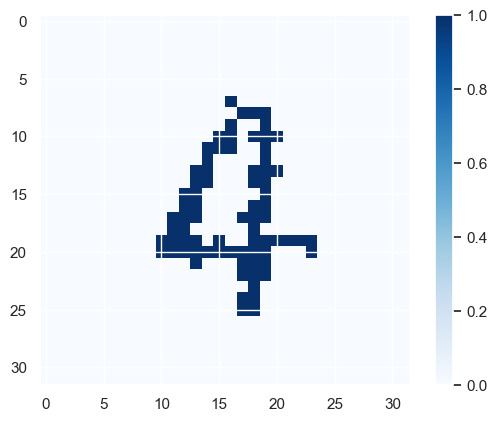

Step 80: Mean Log Likelihood = -673.4324340820312


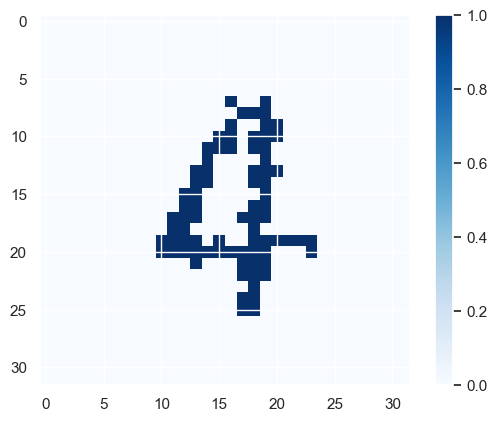

Step 90: Mean Log Likelihood = -672.1503295898438


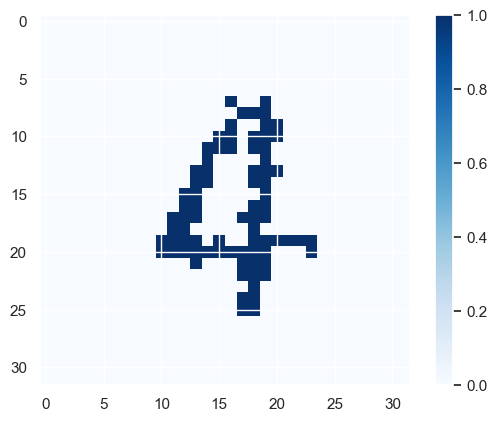

Step 100: Mean Log Likelihood = -670.8681640625


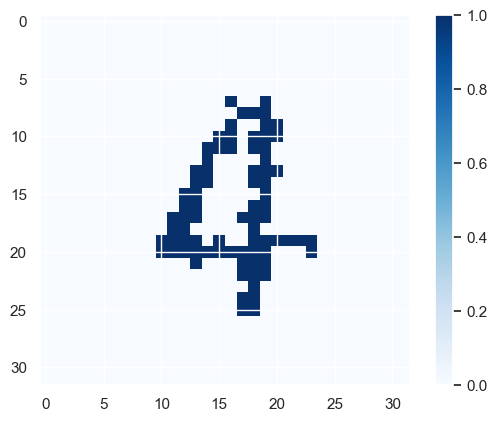

Step 110: Mean Log Likelihood = -670.1083984375


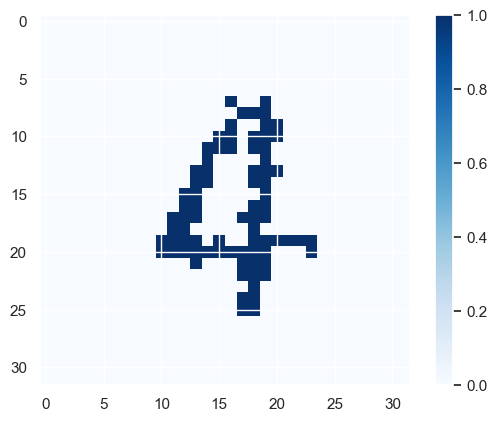

Step 120: Mean Log Likelihood = -669.53857421875


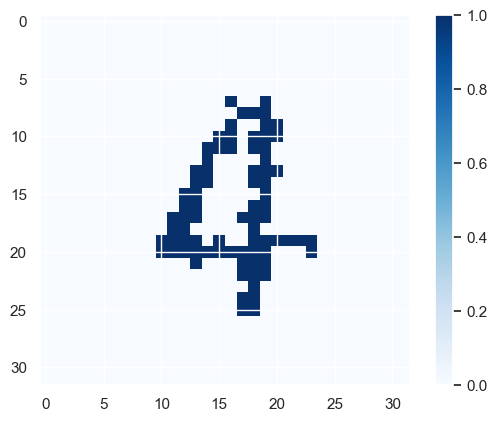

Step 130: Mean Log Likelihood = -669.1824951171875


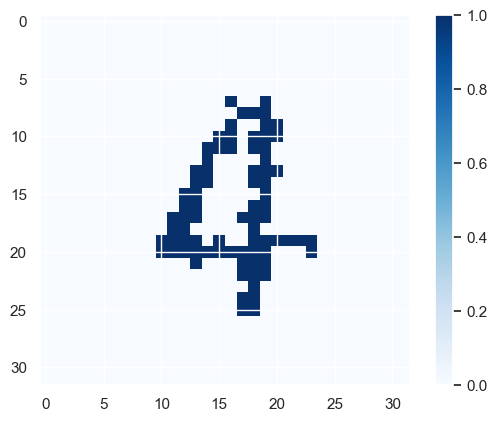

Step 140: Mean Log Likelihood = -669.0875244140625


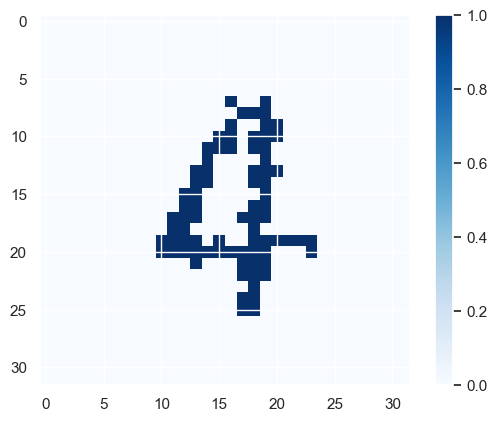

Step 150: Mean Log Likelihood = -669.0875244140625


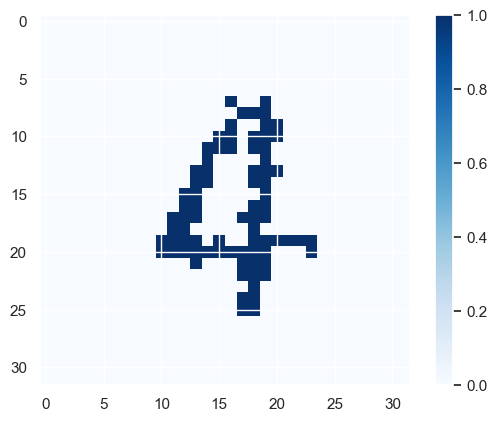

Step 160: Mean Log Likelihood = -669.0875244140625


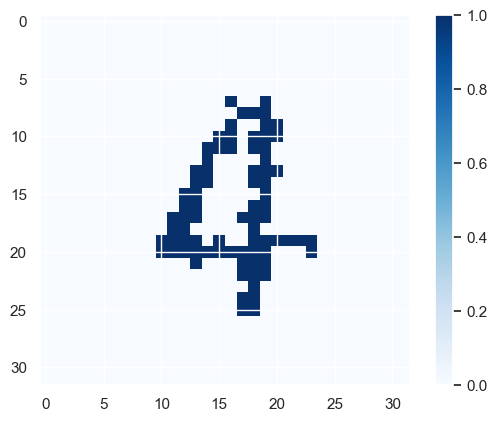

Step 170: Mean Log Likelihood = -669.0875244140625


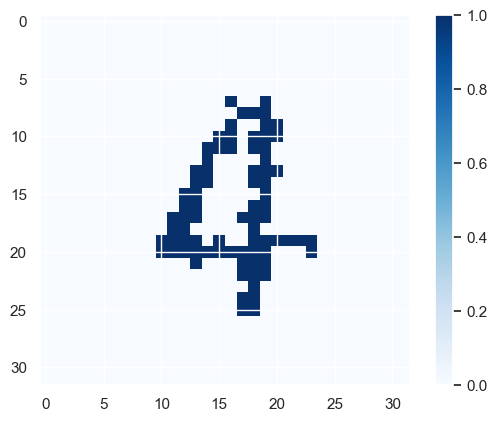

Step 180: Mean Log Likelihood = -669.0875244140625


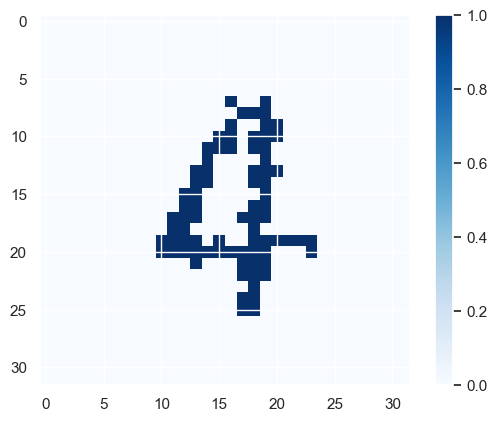

Step 190: Mean Log Likelihood = -669.0875244140625


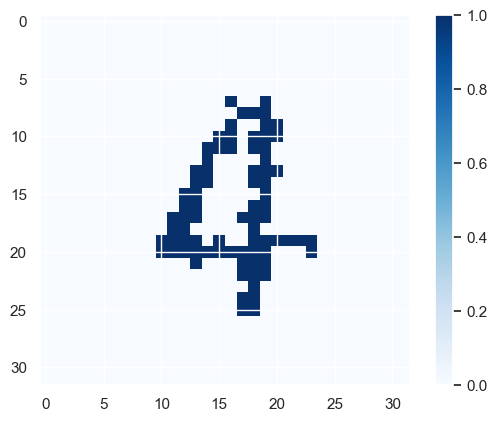

In [180]:
inital_images = images_refill
initial_mask = mask_observed
current_images = inital_images
current_mask = initial_mask

steps = 10  # Calculate log likelihood every 100 steps
step_counter = 0
max_step = 200
recon_value = []

while np.any(~mask_observed) and step_counter< max_step:
    current_images, current_mask = update(current_images, current_mask, key)
    
    if step_counter % steps == 0:
        new_log_likelihood = -binary_cross_entropy(orginial_images, current_images)
        mean_log_likelihood = jnp.mean(new_log_likelihood)
        recon_value.append(-mean_log_likelihood)
        
        print(f"Step {step_counter}: Mean Log Likelihood = {mean_log_likelihood}")
        plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.show()
        
    step_counter += 1
    

Text(0.5, 1.0, 'Reconstruction By Acquiring')

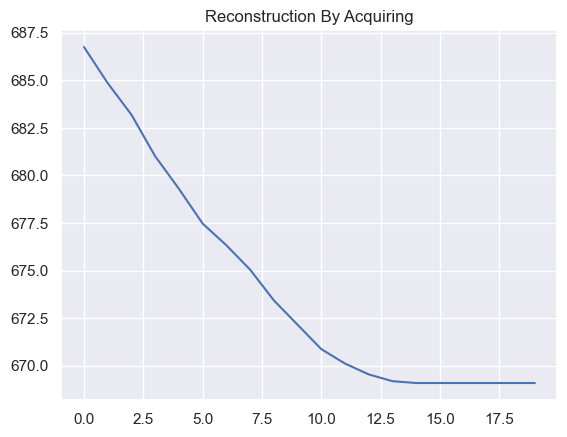

In [181]:
plt.plot(recon_value)
plt.title('Reconstruction By Acquiring')